# Chapter 7. Ulysses' Compass

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [3]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
# az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

**Ockham's razor**: Models w/ fewer assumptions are to be preferred.
- It can be hard to use more generally, because usually we must choose among models that different in both their **accuracy** and their **simplicity**.

**Three fundamental kinds of statistical errors**:
1. Overfitting: matters for causal inference too
2. Underfitting
3. Confounding

This means, when we design any statical model, we must **decide whether we want to understand causes or rather just predict.**
- These are **not the same goal, and different models are needed for each.**

**Mitigating solutions for over-/under-fitting**: they can be (perhaps should be) used in combination.
1. **Regularizing prior**: same as *penalized likelihood* in non-Bayesian methods
2. **Information criteria** or **cross-validation**: estimate predictive accuracy
    - Need to understand *information theory*
    - Information criteria such as AIC, DIC, WAIC, PSIS, are easier to implement than understand; it's a curse!

**Rethinking: Stargazing**
- Stargazing: searching for a model where every coefficient is statistically significant
- **This model is not the best.**: p-values are *not designed to help you navigate between underfitting and overfitting*.

**Rethinking: Is AIC Bayesian?**
- AIC uses *MAP estimates instead of the entire posterior* and *requires flat priors*. (**BIC** is similar in this regard but it's **not actually an information criterion**.
- AIC is a special limit of a Bayesian criterion like WAIC. (Bayesian information criteria like WAIC provide almost exactly the same results as AIC, when AIC's assumptions are met.)
- AIC still has a clear and pragmatic interpretation un Bayesian probability. 

## 7.1. The problem with parameters

**Adding everything to the model is not okay.** The more parameters models have, the more likely they overfit. (Example: inflated $R^{2}$ score)

### 7.1.1. More parameters (almost) always improve fit.

##### Code 7.1: Brain and body mass data

In [4]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


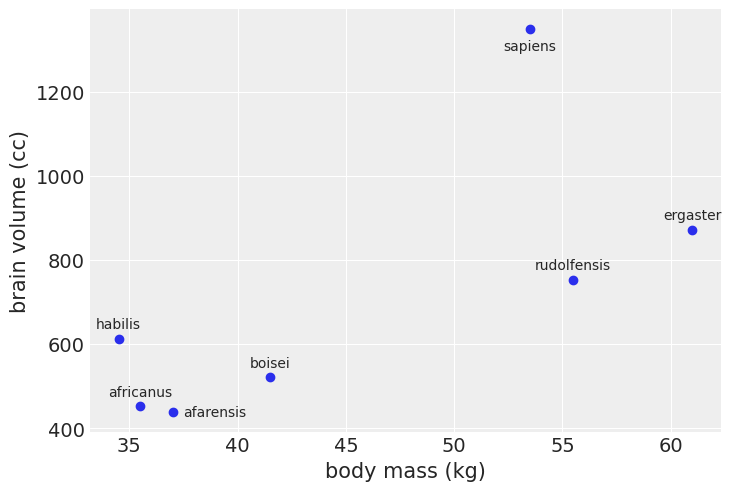

In [5]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

##### Code 7.2: Standardize the data

In [6]:
brains.loc[:, "mass_std"] = (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) / brains.loc[
    :, "mass"
].std()
brains.loc[:, "brain_std"] = brains.loc[:, "brain"] / brains.loc[:, "brain"].max()

##### Code 7.3

In [7]:
d = brains

In [8]:
with pm.Model() as m_7_1:
    
    a = pm.Normal("a", 0.5, 1)
    b = pm.Normal("b", 0, 10)
    sigma = pm.Lognormal("sigma", 0, 1)

    mu = a + b * d.mass_std    
    brain_std = pm.Normal("brain_std", mu=mu, sigma=sigma, observed=d.brain_std)
    
    m_7_1_trace = pm.sample()
    
az.summary(m_7_1_trace, round_to=2)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.53,0.10,0.36,0.74,0.0,0.0,1429.84,785.89,1.00
b,0.16,0.11,-0.04,0.37,0.0,0.0,1495.93,875.79,1.00
sigma,0.26,0.11,0.11,0.44,0.0,0.0,802.73,1113.70,1.01


The notebook exampels are a shorthand for the Bayesian models. They used OLS.

**Rethinking: OLS and Bayesian anti-essentialism**
- It's possible to use **ordinary least-squares (OLS)** to get posterior distributions.
- OLS is not considered a Bayesian algorithm. **But as long as the priors are vague**, minimizing the sum of squared deviations to the regression line is equivalent to finding the posterior mean.
- Like this, **in most cases, a non-Bayesian procedure will have an approximate Bayesian interpretation.**
    - **This is a good thing!**
    - **The Bayesian interpretation of a non-Bayesian procedure** recasts assumptions in terms of information, which is useful for understanding *why a procedure works*.
    - **A Bayesian model can be embodied in an efficient, but approximate, *non-Bayesian* procedure**. Bayesian inference is essentially about approximating the posterior distribution, and it doesn't specify how that approximation is done.

##### Code 7.3
This is modified from [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) (6.2 - 6.6).

In [9]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Mon, 15 Mar 2021   Prob (F-statistic):             0.0798
Time:                        07:46:50   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Code 7.4

In [10]:
p, cov = np.polyfit(brains.loc[:, "mass_std"], brains.loc[:, "brain_std"], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
b,0.167,0.077,0.015,0.300
a,0.530,0.070,0.398,0.661


##### Code 7.5

In [11]:
1 - m_7_1.resid.var() / brains.brain_std.var()

0.49015804794908413

##### Code 7.6

In [12]:
def R2_is_bad(model):
    return 1 - model.resid.var() / brains.brain_std.var()


R2_is_bad(m_7_1)

0.49015804794908413

##### Code 7.7

In [13]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Mon, 15 Mar 2021   Prob (F-statistic):              0.215
Time:                        07:46:50   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.182       1.046
mass_std             0.1957      0.093      2.101      0.104      -0.063       0.454
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.540       0.341
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Code 7.8

In [14]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

##### Code 7.9

In [15]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

##### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
<ipython-input-16-f3ddfe159409>:33: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


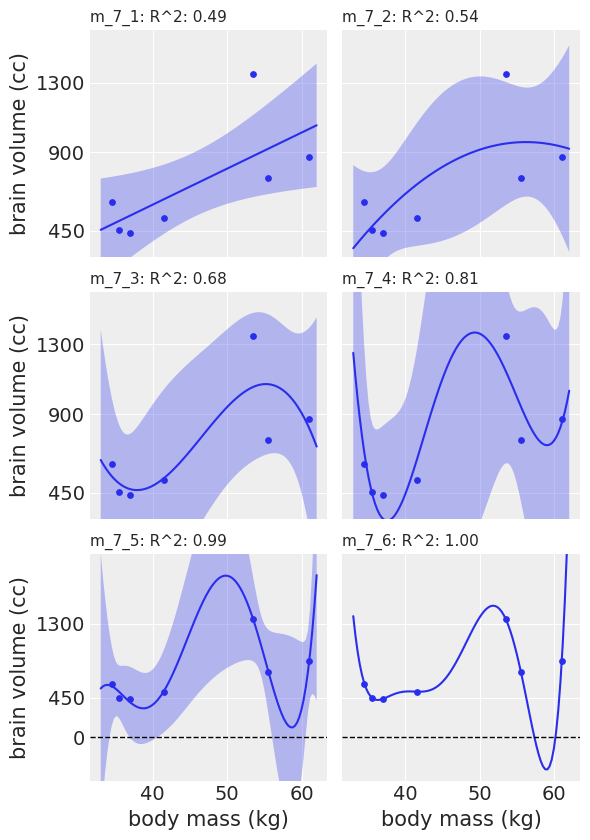

In [16]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

**Rethinking: Model fitting as compression**
- You can consider modeling fitting as a form of **data compression*.
- Overfitting means the data compression isn't really happening.
- Learning about the data requires using a simpler model that achieves some compression, but not too much.
- This view of model selection is known as **minimum description length (MDL)**.

##### Code 7.11 - this is R specific notation for dropping rows

In [17]:
brains_new = brains.drop(brains.index[-1])

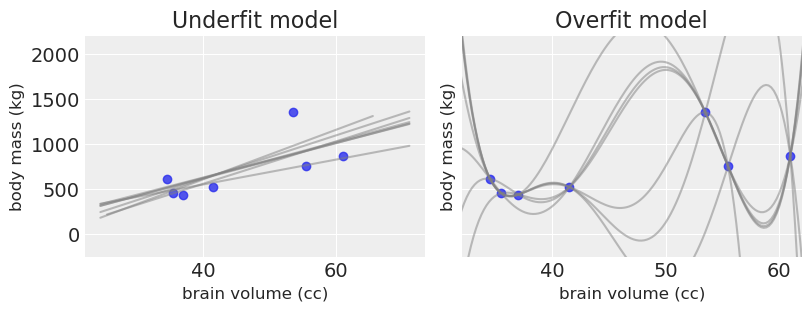

In [18]:
# Figure 7.4

# this code taken from PyMC3 port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

**Rethinking:: Bias and variance**
- Bias-variance trade-off: essentially underfitting (too biased and can't predict well) and overfitting (prediction too variable)

## 7.2. Entropy and accuracy

We need to pick a criterion of model performance (=**target**). We're interested in *out-of-sample* deviance. How to do it:
1. We need to establish a measurement scale -> information theory
2. We need to establish *deviance* as an approximation of relative distance from perfect accuracy
3. We need to establish that it's only deviance *out-of-sample* that is of interest.

### 7.2.1. Firing the weatherperson
Accuracy depends on the definition of the target. Two things to consider:
1. Cost-benefit analysis
2. Accuracy in context

#### 7.2.1.2. Measuring accuracy
- Log scoring rule: log probability

### 7.3.2. Information and uncertainty
- We want to use the *log prob. of the data* to score the accuracy of competing models.
- Next question: how to measure distance from perfect prediction.

**Information theory**
- Deep connections to Bayesian inference
- Basic insight: *How much is our uncertainty reduced by learning an outcome?*
- The measured decrease in uncertainty = definition of information
    - *Informaiton*: the reduction in uncertainty when we learn an outcome

**Desiderata**
1. Should be continuous.
2. Should increase as the number of possible events increases.
3. Should be additive.

**Information entropy**
- Definition: *The uncertainty contained in a probability distribution is the **average log-probability of an event**.*
$$H(p) = -\text{E}\log(p_{i}) = - \sum_{i=1}^{n}p_{i}\log(p_{i})$$
- When $p_{i} = 0$ then entropy is also 0.

##### Code 7.12

In [16]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

**Rethinking: The benefit of maximizing uncertainty**
- *Maximum entropy (maxent)*: a family of techniques for including probability distributions that are most consistent with states of knowledge. In other words, **given what we know, what's the least surprising distribution?**.
- One way to answer this is to use the prior knowledge as contratin.
    - If we do this, we get the posterior distribution. 
    - Thus, **Bayesian updating is entropy maximization**.
- It's also useful for building GLMs.

### 7.2.3. From entropy to accuracy
Now we need to measure how far a model is from the target: **Divergence**
- *The additional uncertainty induced by using probabilities from one distribution to describe another distribution* = Kullback-Leibler divergence (KL divergence)

Divergence = **the average difference in log probability between the target (p) and the model (q)**.

$$D_{KL}(p, q) = \sum_{i}p_{i}(\log(p_{i}) - \log(q_{i})) = \sum_{i}p_{i}\log(\frac{p_{i}}{q_{i}})$$

- If q becomes more different from p, $D_{KL}$ also increases.
- Since predictive models specify probabilities of observations, we can use divergence to compare the accuracy of models.

**Cross entropy and divergence**
- When we use a probability distribution q to predict events from another distribution p, this defines cross entropy: $H(p, q) = -\sum_{i}p_{i}\log(q_{i})$
- Divergence is defined as *the additional entropy* induced by using q. Thus, it's the difference between $H(p)$, the actual entropy of events, and $H(p, q)$:
$$D_{KL}(p, q) = H(p, q) - H(p)$$

**Rethinking: Divergence depends upon direction**
- An important practical consequence of this asymmetry, in a model fitting context, is that *if we use a distribution with **high entropy** to approximate an unknown true distribution of events, we will **reduce the distance to the truth and therefore the error***.

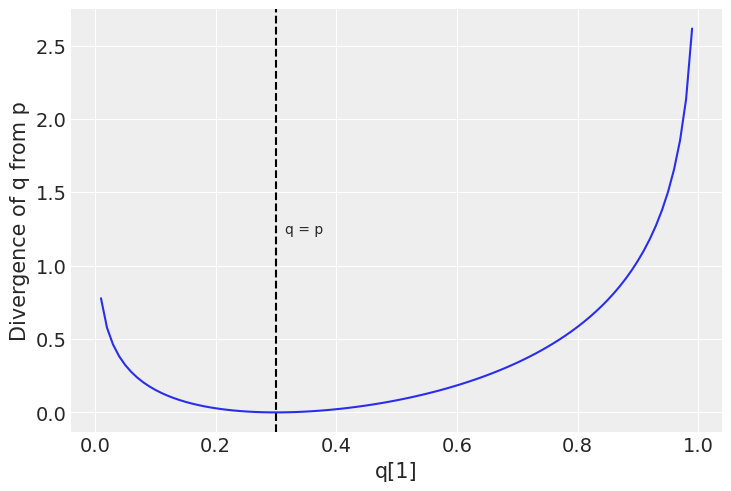

In [19]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

### 7.2.4. Estimating divergence

To use $D_{KL}$, we need to know p. We can't know p. But it's okay because we can subtract p out. This also means that we just need to know the *model's average log-probability*: $E\log(q_{i})$. To pull this into practice, it's conventional to sum over all observations, yielding a total score for a model q:
$$S(q) = \sum_{i}\log(q_{i})$$

To compute this we need to use the *entire posterior distribution*. Otherwise, we will be throwing away information. **How can we use the entire distribution of predictions?**
- We need to find the log of the average probability for each observation where the average is taken over the posterior distribution. For some data $y$ and posterior distrubtion $\Theta$:

$$lppd(y, \Theta) = \sum_{i}\log \frac{1}{S} \sum_{s} p(y_{i}|\Theta_{s})$$

- lppd: Bayesian version of the log probability score.
    - Essentially, sum of the
        - log of the
            - average of posterior samples
- $S$: number of samples, $\Theta_{s}$: s-th set of sampled parameter values in the posterior distribution.
- Larger the better. (larger average accuracy)

**Deviance**: -2 x lppd

In [20]:
m_7_1.params

Intercept    0.528677
mass_std     0.167118
dtype: float64

##### Code 7.13 & 7.14: Computing log-pointwise predictive-density (LPPD)

In [21]:
n_samples = 3000

# sampling from multivariate normal distribution
# kinda hard to understand because m_7_1 is not a pymc3 model
intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T
pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)
n, ns = pred.shape

PyMC3 does not have a way to calculate LPPD directly, so we use the approach from 7.14. *But, pymc3's WAIC has lppd implementation in it (there's no direct method though)*.

In [22]:
# PyMC3 does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.6142741 ,  0.65365724,  0.56090942,  0.62382269,  0.47779088,
        0.44813583, -0.85617862])

### 7.2.5. Scoring the right data
- The log-probability score has the same problem as $R^{2}$;  complex models return higher values.
- We can solve this by using test sample (this is also our interest).
- We need to compute train and test scores.

##### Code 7.15

In [25]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [26]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.56660628,  2.33712593,  2.83815748,  3.53625209, 11.14463621])

##### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [27]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc3

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            testval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

In [28]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


Deviance is **an assessment of predictive accruacy, not of truth**.
- Deviance on training data **always improves** w/ additional predictor variables.
- Deviance on testing data may or may not, depending on
    1. True data-generating process
    2. How much data is available to precisely estimate the parameters.

##### Code 7.17

Does not apply because multi-threading is automatic in PyMC3.

##### Code 7.18

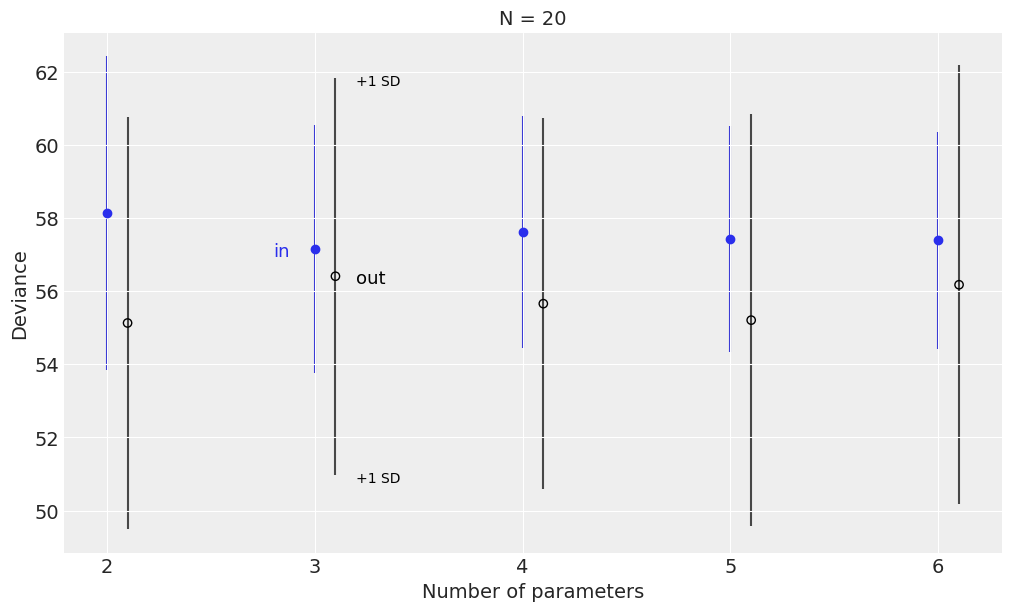

In [29]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

## 7.3. Golem taming: regularization

Regularization is about applying a *skeptical* prior (= prior that **slows the rate of learning**).
- **skeptical** prior = narrow prior
- Too strong (too narrow) -> underfitting

**Multilevel models**' central device is to **learn the strength of the prior from the data itself**.

**Rethinking: Ridge regression**
- Ridge regression: linear models where slope parameters use Gaussian priors centered at zero
- $\lambda$: essentially the narrowness of the prior; larger $\lambda$ -> less overfitting
- Another example of how a statistical procedure can be understood from both Bayesian and non-Bayesian perspectives.
- Ridge doesn't compute a posterior distribution.

#### Code 7.19

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

In [25]:
data = pd.read_csv("Data/cars.csv", sep=",", index_col=0)

In [26]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed=data["dist"])
    m = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9001272065370016, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026576928641691, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 7.20

In [27]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = m["a"][s] + m["b"][s] * data["speed"]
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=m["sigma"][s])
    logprob[:, s] = p_

#### Code 7.21

In [28]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

#### Code 7.22

In [29]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])

#### Code 7.23

In [30]:
-2 * (sum(lppd) - sum(pWAIC))

412.6108691539448

#### Code 7.24

In [31]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec)) ** 0.5

14.899077273179385

#### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [32]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


#### Code 7.25

In [33]:
az.waic(m_6_7_trace, m_6_7, scale="deviance")

/Users/ksachdeva/Desktop/Dev/myoss/resources/env/lib/python3.6/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   310.70    15.05
p_waic            3.64        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

#### Code 7.26

In [34]:
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,310.701,3.63783,0,1,15.0544,0,True,deviance
m_6_8,1,404.15,2.98167,93.4489,5.10295e-21,13.0614,14.275,True,deviance
m_6_6,2,407.821,1.83157,97.1199,8.14123e-22,12.7769,13.6224,False,deviance


#### Code 7.27

In [35]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

/Users/ksachdeva/Desktop/Dev/myoss/resources/env/lib/python3.6/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


array(14.27496158)

#### Code 7.28

In [36]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

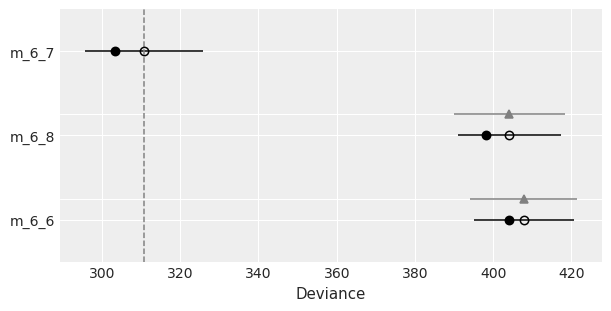

In [37]:
az.plot_compare(compare_df);

#### Code 7.30

In [38]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale="deviance")

diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i

n = len(diff_m6_6_m6_8)

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(6.67535214)

#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison. This is not implemented in `arviz`, but we can hack it together:

In [39]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

/Users/ksachdeva/Desktop/Dev/myoss/resources/env/lib/python3.6/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,m_6_7,m_6_8
m_6_8,14.275,0
m_6_6,13.6224,6.67535


**Note:** this work for three models, but will get increasingly hack-y with additional models. The function below can be applied to *n* models:

In [40]:
def pairwise_compare(dataset_dict, metric="dse", **kwargs):
    """
    Calculate pairwise comparison of models in dataset_dict.

    Parameters
    ----------
    dataset_dict : dict
        A dict containing two ore more {'name': pymc3.backends.base.MultiTrace}
        items.
    metric : str
        The name of the matric to be calculated. Can be any valid column output
        by `arviz.compare`. Note that this may change depending on the **kwargs
        that are specified.
    kwargs
        Arguments passed to `arviz.compare`
    """
    data_dict = dataset_dict.copy()
    dicts = []

    while len(data_dict) > 1:
        c = az.compare(data_dict, **kwargs)[metric]
        dicts.append(c.to_frame(name=c.index[0]))
        del data_dict[c.index[0]]

    return pd.concat(dicts, axis=1)

In [41]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

pairwise_compare(dataset_dict, metric="dse", ic="waic", scale="deviance")

/Users/ksachdeva/Desktop/Dev/myoss/resources/env/lib/python3.6/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,m_6_7,m_6_8
m_6_7,0,NaN
m_6_8,14.275,0
m_6_6,13.6224,6.67535


#### Code 7.32

In [42]:
d = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [43]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_3_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


#### Code 7.33

In [44]:
az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance",
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,126.694,3.61301,0,0.685679,13.1167,0,False,deviance
m_5_3,1,128.996,4.92241,2.30205,0.233821,9.47916,0.774294,False,deviance
m_5_2,2,140.188,2.87732,13.4935,0.0805001,13.3214,9.12875,False,deviance


#### Code 7.34

/Users/ksachdeva/Desktop/Dev/myoss/resources/env/lib/python3.6/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


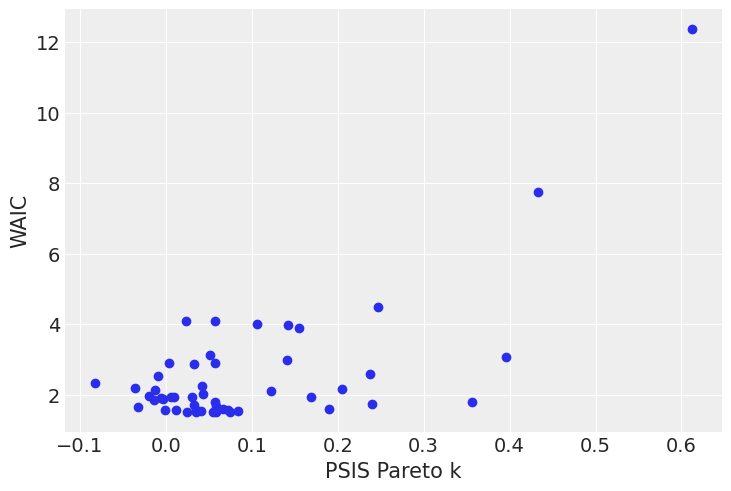

In [45]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

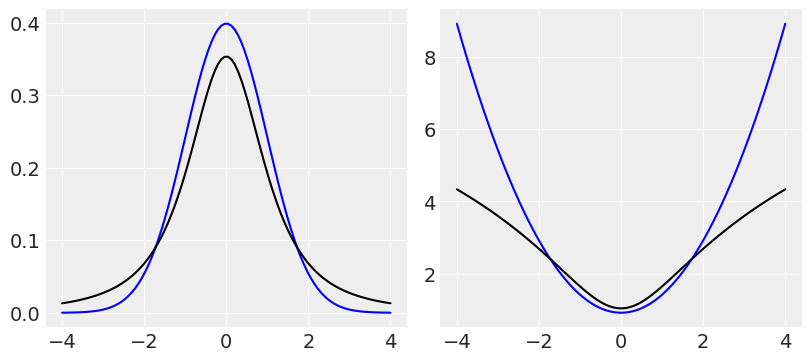

In [46]:
# Figure 7.11

v = np.linspace(-4, 4, 100)

g = stats.norm(loc=0, scale=1)
t = stats.t(df=2, loc=0, scale=1)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.pdf(v), color="b")
ax.plot(v, t.pdf(v), color="k")

lax.plot(v, -g.logpdf(v), color="b")
lax.plot(v, -t.logpdf(v), color="k");

#### Code 7.35

In [47]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", 2, mu, sigma, observed=d["D"])

    m_5_3t_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [48]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 4000 by 50 log-likelihood matrix

             Estimate       SE
deviance_loo   133.57    10.71
p_loo            5.56        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

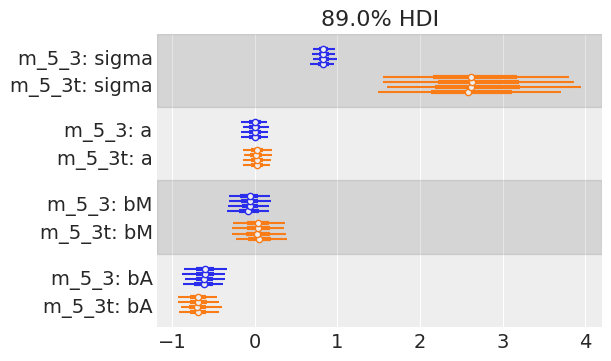

In [49]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas          1.1.1
numpy           1.19.1
pymc3           3.9.3
arviz           0.9.0
statsmodels.api 0.11.1
last updated: Mon Aug 24 2020 

CPython 3.6.10
IPython 7.16.1
watermark 2.0.2
